In [151]:
!pip install nltk
!pip install google-play-scraper

import re
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
from wordcloud import WordCloud
from google_play_scraper import app

import matplotlib.pyplot as plt
import nltk
from nltk.stem.rslp import RSLPStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('rslp')

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import confusion_matrix, classification_report

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Package rslp is already up-to-date!


In [216]:
# Método responsável por aplicar as transformações necessárias para melhorar
# a qualidade dos textos analisados.
def preprocess(textdata):
    processedText = []
    
    # Lematização
    wordLemm = RSLPStemmer()
    
    # Regex para remoção de urls, usuários, não alfabéticos e repetições
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern       = '@[^\s]+'
    alphaPattern      = "[^a-zA-Z0-9]"
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"
    
    for text in textdata:
        text = text.lower()
        
        # Substituindo cada possível url por ' URL'
        text = re.sub(urlPattern,' URL',text)
        
        # Substituindo os emojis pelos seus valores
        for emoji in emojis.keys():
            text = text.replace(emoji, "EMOJI" + emojis[emoji])        
        
        # Substituindo o @nomeusuario por 'USER'.
        text = re.sub(userPattern,' USER', text)        
        
        # Removendo todos textos não alfabéticos
        text = re.sub(alphaPattern, " ", text)
        
        # Substituindo repetições de caracteres excessivas
        text = re.sub(sequencePattern, seqReplacePattern, text)

        textwords = ''
        for word in text.split():
            # Verificando se a palavra não é uma stopword
            if word not in stopwords:
                # Se não, verificar se tem 2 ou mais chars e lematizar
                if len(word) >= 2:
                    # Lematização das palavras
                    word = wordLemm.stem(word)
                    textwords += (word+' ')
            
        processedText.append(textwords)
        
    return processedText

In [217]:
# Definindo os emojis que serão substituídos pelos seus significados
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

#Criando a lista de stopwords
# stopwordlist  = stopwords.words('portuguese')
stopwords=nltk.corpus.stopwords.words('portuguese')
stopwords = list(set(stopwords))

In [156]:
def predict(vectoriser, model, text):
    # Prediz o sentimento
    textdata = vectoriser.transform(preprocess(text))
    sentiment = model.predict(textdata)
    
    # Monta a lista dos sentimmentos preditos
    data = []
    for text, pred in zip(text, sentiment):
        data.append((text,pred))
        
    # Gera um pandas df com os dados
    df = pd.DataFrame(data, columns = ['Texto','Sentimento'])
    df = df.replace([0,1], ["Negativo","Positivo"])
    return df

In [157]:
result = app('com.itau', lang = 'pt', country = 'br')
result

{'adSupported': None,
 'androidVersion': '5.0',
 'androidVersionText': '5.0 ou superior',
 'appId': 'com.itau',
 'comments': ['Aplicativo apresentando não funcionamento em questão a parte de lançamentos futuros, entradas e saídas a dias. Já desinstalei e instalei novamente mas não corrigiu meu problema e é algo que eu gostaria muito que estivesse aparecendo. No próprio aplicativo você tenta fazer coisas simples que não é possível pois não funciona de forma satisfatória. Venho por meio dessa plataforma informar pois no próprio aplicativo não estou conseguindo fazer essa observação.',
  'Mais uma vez eu não consigo abrir o app do Itaú, é complicado porque esses bugs atrapalham para quem depende da conta para movimentá-la. Os apps das fintechs raramente dão esse tipo de problema, espero que o Itaú na qualidade do maior banco do país e um dos maiores do mundo deveria resolver em definitivo esse tipo de problema. Se continuar desse jeito, vou ser obrigado a priorizar outros bancos em detrim

In [159]:
#Baixando todos os reviews do app.
from google_play_scraper import Sort, reviews_all

#Comando para todas as reviews
Reviews = reviews_all('com.nu.production', lang = 'pt', country = 'br', sort = Sort.NEWEST, sleep_milliseconds = 0)

In [211]:
#Importando pandas.
import pandas as pd

#Transformando os dados em um DataFrame para trabalharmos as análises.
Reviews_Agi = pd.DataFrame(Reviews)

#Verificando a serie de dados.
Reviews_Agi

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt
0,gp:AOqpTOGdKehUWcFfVObU8piyNmiWXPEE67uBfhG5mwh...,Luciana,https://play-lh.googleusercontent.com/a-/AOh14...,Nao tive nenhum problema com o nubank Estou go...,5,0,6.86.1-minApi21,2021-11-14 20:58:19,None,NaT
1,gp:AOqpTOH9CZBJKQPu2JKv7ndOr-gkl9Z0rXrZ9wnFrag...,Jardene Barros,https://play-lh.googleusercontent.com/a/AATXAJ...,Ótimo muito fácil,5,0,6.86.1-minApi21,2021-11-14 20:57:33,None,NaT
2,gp:AOqpTOHc6EfDUEPLch8gFqKZ_V46msxqERrEmfgbxpG...,Lucas Lima,https://play-lh.googleusercontent.com/a-/AOh14...,"Gostei, mas deveria aumentar meu limite né rs",5,0,6.76.0-minApi21,2021-11-14 20:54:00,None,NaT
3,gp:AOqpTOExOtOrSXOTWpGtv5HD5K8kV1ppAftbNblOSso...,Luiz Carlos T Melem Carlos,https://play-lh.googleusercontent.com/a/AATXAJ...,Pra mim esse é um dos melhores aplicativos que...,4,0,6.86.1-minApi21,2021-11-14 20:53:37,None,NaT
4,gp:AOqpTOEkbqj6j95Nk7D_e01vX_eVRCXHM3K6oY_NMe1...,claudineia lourenco,https://play-lh.googleusercontent.com/a/AATXAJ...,"Gosto demais e super indico, ele tem todas fac...",5,0,6.86.1-minApi21,2021-11-14 20:51:12,None,NaT
...,...,...,...,...,...,...,...,...,...,...
403164,gp:AOqpTOEoq9X6RjqH1JSYm7H-0taFbKO1cKBfFYUMyyv...,Andre Berbert,https://play-lh.googleusercontent.com/a/AATXAJ...,Tudo que precisamos saber da utilizacao de um ...,5,1,1.8.2,2014-08-23 12:34:54,"Obrigada Andre, estamos avaliando com carinho ...",2015-03-05 18:44:58
403165,gp:AOqpTOEQ9eqd8z5vidzJogtdqHew2QISI2jO5dswHe0...,Daniela Mazer,https://play-lh.googleusercontent.com/a/AATXAJ...,Simples e funcional,5,0,1.8.2,2014-08-22 12:54:11,Obrigada pela mensagem Daniela :-),2015-03-05 18:44:18
403166,gp:AOqpTOEe0KnB0aGKUZk6b-8u5Ly_b9SsCjPrz55jpzT...,Breno Masi,https://play-lh.googleusercontent.com/a-/AOh14...,"Recomendo, excelente!",5,0,1.7.1,2014-07-18 06:13:57,"Obrigada Breno, agradecemos a mensagem e esper...",2015-03-05 18:43:15
403167,gp:AOqpTOEYqWKVTSQ5p8k6h5LcUZXfitDNtmPO--r3K6R...,João Luis Olivério,https://play-lh.googleusercontent.com/a-/AOh14...,Melhor cartão de crédito! Excelente atendimento!,5,0,None,2014-07-07 22:43:45,"Obrigada João, ficamos contentes por estar gos...",2015-03-05 18:42:34


In [212]:
Reviews_Agi.drop(['reviewId', 'userName', 'userImage', 'reviewCreatedVersion', 'at', 'replyContent', 'repliedAt', 'thumbsUpCount'], axis=1, inplace=True)
Reviews_Agi.head(50)

,content,score
0,Nao tive nenhum problema com o nubank Estou go...,5
1,Ótimo muito fácil,5
2,"Gostei, mas deveria aumentar meu limite né rs",5
3,Pra mim esse é um dos melhores aplicativos que...,4
4,"Gosto demais e super indico, ele tem todas fac...",5
5,Simplesmente ótimo...porém não chega notificaç...,5
6,Quase um ano usando esse aplicativo e nunca au...,1
7,@nubank eu não estou conseguindo atualizar não...,1
8,Neste domingo dia 14 de novembro de 2021 não e...,1
9,Ótimo,5


In [213]:
Reviews_Agi['score'].replace(1, 0, inplace=True)
Reviews_Agi['score'].replace(2, 0, inplace=True)
Reviews_Agi['score'].replace(3, 0, inplace=True)
Reviews_Agi['score'].replace(4, 1, inplace=True)
Reviews_Agi['score'].replace(5, 1, inplace=True)
Reviews_Agi = Reviews_Agi.replace(to_replace='None', value=np.nan).dropna()

In [214]:
Reviews_Agi.head(50)

,content,score
0,Nao tive nenhum problema com o nubank Estou go...,1
1,Ótimo muito fácil,1
2,"Gostei, mas deveria aumentar meu limite né rs",1
3,Pra mim esse é um dos melhores aplicativos que...,1
4,"Gosto demais e super indico, ele tem todas fac...",1
5,Simplesmente ótimo...porém não chega notificaç...,1
6,Quase um ano usando esse aplicativo e nunca au...,0
7,@nubank eu não estou conseguindo atualizar não...,0
8,Neste domingo dia 14 de novembro de 2021 não e...,0
9,Ótimo,1


In [215]:
Reviews_Agi.groupby('score').describe()

content                          
        count  unique        top   freq
score                                  
0       85130   80806        Bom    550
1      318018  193617  Muito bom  14774

In [218]:
import time
t = time.time()

# Atribuindo os valores da coluna content a uma lista e coluna score a outra
text, score = list(Reviews_Agi['content']), list(Reviews_Agi['score'])

processedtext = preprocess(text)
print(f'Pré-processamento de texto completo.')
print(f'Tempo total: {round(time.time()-t)}s')

Pré-processamento de texto completo.
Tempo total: 168s


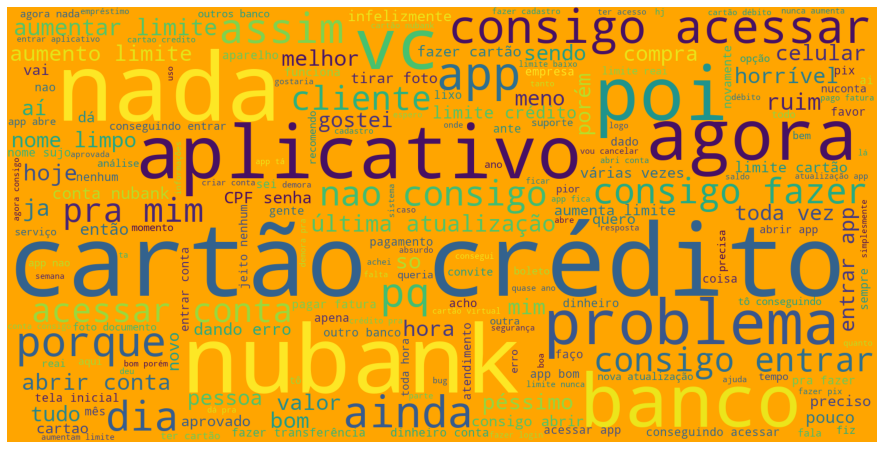

In [219]:
Negative = Reviews_Agi[Reviews_Agi.score == 0]
Neg_Content = Negative['content']
all_neg_content = "".join(c for c in Neg_Content)
wordcloud = WordCloud(stopwords=stopwords,
                      background_color='orange', width=1600,                            
                      height=800).generate(all_neg_content)


fig, ax = plt.subplots(figsize=(16,8))            
ax.imshow(wordcloud, interpolation='bilinear')       
ax.set_axis_off()
plt.imshow(wordcloud)

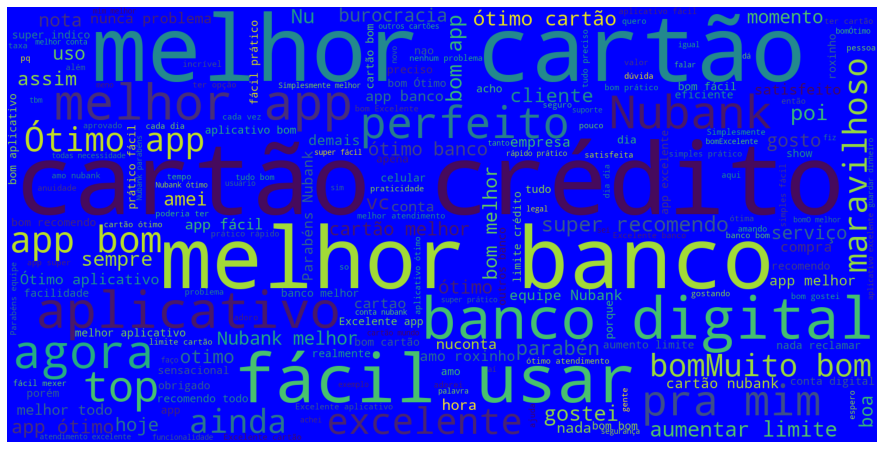

In [220]:
Positive = Reviews_Agi[Reviews_Agi.score == 1]
Pos_Content = Positive['content']
all_pos_content = "".join(c for c in Pos_Content)
wordcloud = WordCloud(stopwords=stopwords,
                      background_color='blue', width=1600,                            
                      height=800).generate(all_pos_content)


fig, ax = plt.subplots(figsize=(16,8))            
ax.imshow(wordcloud, interpolation='bilinear')       
ax.set_axis_off()
plt.imshow(wordcloud)

In [221]:
X_train, X_test, y_train, y_test = train_test_split(processedtext, score, test_size = 0.2, random_state = 0)
print(f'Separação dos dados finalizada.')

Separação dos dados finalizada.


In [222]:
vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectorizer.fit(X_train)
print('Número de features: ', len(vectorizer.get_feature_names()))

Número de features:  414225


In [226]:
# Gerando os datasets X_train e X_test que serão utilizados para treinamento e teste
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)
print(f'Dados de treino e teste gerados')

Dados de treino e teste gerados


In [223]:
corpus = Negative['content'].tolist()

X = vectorizer.fit_transform(corpus)
feature_array = vectorizer.get_feature_names()

top_n = 10

vectorizer = CountVectorizer(stop_words=stopwords)
X = vectorizer.fit_transform(corpus)
feature_array = vectorizer.get_feature_names()
print('Frequency: \n', sorted(list(zip(vectorizer.get_feature_names(), 
                                         X.sum(0).getA1())),
                            key=lambda x: x[1], reverse=True)[:top_n])

Frequency: 
 [('app', 23256), ('cartão', 21475), ('conta', 18485), ('pra', 15696), ('limite', 15677), ('consigo', 14790), ('aplicativo', 12140), ('crédito', 11133), ('nubank', 10469), ('nao', 10103)]


In [224]:
corpus = Positive['content'].tolist()

X = vectorizer.fit_transform(corpus)
feature_array = vectorizer.get_feature_names()

top_n = 10

vectorizer = CountVectorizer(stop_words=stopwords)
X = vectorizer.fit_transform(corpus)
feature_array = vectorizer.get_feature_names()
print('Frequency: \n', sorted(list(zip(vectorizer.get_feature_names(), 
                                         X.sum(0).getA1())),
                            key=lambda x: x[1], reverse=True)[:top_n])

Frequency: 
 [('bom', 75749), ('melhor', 49211), ('cartão', 45189), ('ótimo', 44431), ('app', 43401), ('banco', 29607), ('nubank', 28629), ('excelente', 27482), ('aplicativo', 21305), ('crédito', 16013)]


              precision    recall  f1-score   support

           0       0.72      0.49      0.58     16969
           1       0.87      0.95      0.91     63661

    accuracy                           0.85     80630
   macro avg       0.80      0.72      0.75     80630
weighted avg       0.84      0.85      0.84     80630



Text(0.5, 1.0, 'Matriz de Confusão')

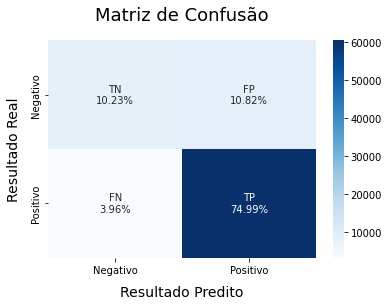

In [227]:
model = LogisticRegression(C = 2, max_iter = 50000, n_jobs=-1)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

# Montando a matriz de confusão pelo sklearn
cf_matrix = confusion_matrix(y_test, y_pred)

# Definindo as categorias da matriz
categories  = ['Negativo','Positivo']
group_names = ['TN','FP', 'FN','TP']
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
            xticklabels = categories, yticklabels = categories)

plt.xlabel("Resultado Predito", fontdict = {'size':14}, labelpad = 10)
plt.ylabel("Resultado Real"   , fontdict = {'size':14}, labelpad = 10)
plt.title ("Matriz de Confusão", fontdict = {'size':18}, pad = 20)

In [237]:
# Texto de teste
text = ["Este aplicativo é muito ruim, vc deveria liberar mais limite",
        "Este aplicativo é muito bom, tem bastante limite",
        "Muito ruim de usar, lento travaaaa",
        "O app é maravilhoso, funciona mto rápido e tem tudo",
        "lixooooo",
        "Uso sempre e tem bom cartao e interface"]

# Gera um dataframe com os resultados
df = predict(vectoriser, model, text)
print(df)

                                               Texto Sentimento
0  Este aplicativo é muito ruim, vc deveria liber...   Negativo
1   Este aplicativo é muito bom, tem bastante limite   Positivo
2                 Muito ruim de usar, lento travaaaa   Negativo
3  O app é maravilhoso, funciona mto rápido e tem...   Positivo
4                                           lixooooo   Negativo
5            Uso sempre e tem bom cartao e interface   Positivo
